# Credit Analysis
    a.	Preprocess and clean if necessary.
    b.	Build a model predicting “Risk”. 
    c.	Remember to comment your code and give rationales for models, algorithms, and approaches. 


## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

## Load data

In [ ]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [ ]:
df=pd.read_sql_table(r"credit_train",engine_datahub)
df.head()

## Exploratory Data Analysis(EDA)



### Check missing values and shape
Normally we need to clean the samples, i,e, impute missing values but in this case the data is pretty clean with no missing values. We also check the shape to make sure it matches the meta data info in the document. 

In [ ]:
df.info(), df.shape

### Check Loan Status ratio
The samples are balanced so we can use "Accuracy" metric to measure the performance of the model

In [ ]:
df['Loan Status'].value_counts().plot(kind='bar')

### Describe the data

Categorical features/Dimensions 

In [ ]:
cat_cols=df.select_dtypes(object).drop(['Loan ID','Customer ID'],axis=1).columns.tolist()
cat_cols

In [ ]:
import matplotlib.pyplot as plt
categorical_features = cat_cols
# fig, ax = plt.subplots(1, len(categorical_features))
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i],figsize=(20,8),rot=90,fontsize=10).set_title(categorical_feature)
fig.show()

Numeric data

#### Histogram
Histogram groups numeric data into bins, displaying the bins as segmented columns and summarize the distribution of a univariate data set. 

In [ ]:
num_cols=df.select_dtypes('number').columns.tolist()
num_cols

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(6, 2, figsize=(20, 20))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.distplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],bins=50)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

fig, ax = plt.subplots(6, 2, figsize=(15, 25))

#plot the features except LOCATION_ID and Risk
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
#         sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v',showfliers=False)
        sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v')

In [ ]:
df.describe()
# from the "max" row we can see feature PARA_A, PARA_B,Money_Value,History have some potential outliers. 

In [ ]:
df['Credit Score']=np.where(df['Credit Score']>=1000,df['Credit Score']/10,df['Credit Score'])

In [ ]:
df['Current Loan Amount']=np.where(df['Current Loan Amount']==99999999,df['Current Loan Amount'].median(),df['Current Loan Amount'])

In [ ]:
df.describe()

### Clip, i.e. assigns values outside boundary to boundary values, the data to deal with outliers. 
 Outliers may distort how we see the data. They contain information too so it's a tradeoff; we lose some info but gain a better big picture of the data.

In [ ]:
df['Years in current job']=df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)

In [ ]:
# here we use quantile 0.01 as lower limit and 0.99 upper.
df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)
df.describe()

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(6, 2, figsize=(20, 25))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.distplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],bins=50)

### Boxplot the data
Boxplot shows the shape of the distribution, its central value, and its variability

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

fig, ax = plt.subplots(6, 2, figsize=(15, 25))

#plot the features except LOCATION_ID and Risk
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(df[df[num_cols].columns[i*2+j]], ax=ax[i][j],orient='v',showfliers=False)

#### Explain the Boxplots:
The boxplots tell similar story as the Histograms. None of the distributions seem normal.

### Correlation heatmap
Correlation heatmap allows us to see relations between features/attributes. The higher the absolute coefficient, the stronger the correlation is. 

In [ ]:
import seaborn as sns
df=df.query('`Loan ID`.notnull()', engine='python')
sns.pairplot(df.sample(frac=0.01, replace=True).reset_index(drop=True),plot_kws=dict(marker="+", linewidth=1))

In [ ]:

# df['Loan Status encoded']=np.where(df['Loan Status']=='Fully Paid',0,1)
corrMatrix = df.corr()
plt.figure(figsize = (12,9))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()

# Categorical vs Categorical

In [ ]:
#Plot each attribute vs Class in percentage
y = 'Loan Status'
for i, predictor in enumerate(df[cat_cols].drop(columns=['Loan Status'])):
    plt.figure(i)
    df1 = df.groupby(predictor)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=predictor,y='percent',hue=y,kind='bar',data=df1,
                    palette=sns.color_palette(['lightseagreen', 'tomato']),height=8.27, aspect=11.7/8.27)
    g.set_xticklabels(rotation=30)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(np.nan_to_num(p.get_height().round(2))) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        txt_y=np.nan_to_num(txt_y)
        g.ax.text(txt_x,txt_y,txt)

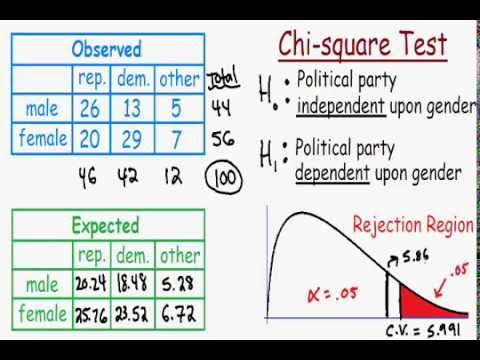

In [ ]:
from scipy.stats import chisquare,chi2_contingency

v1=df['Term']
# v1=df['Purpose']
# v2=df['Home Ownership']
v2=df['Loan Status']
# g, p, dof, expctd=chi2_contingency(pd.crosstab(v1, v2))
print('Chi Square p value =' , chi2_contingency(pd.crosstab(v1, v2))[1])

display(pd.crosstab(v1, v2))
display(pd.crosstab(v1, v2,normalize='index'))
# sns.heatmap(pd.crosstab(v1, v2), annot=True)
sns.heatmap(pd.crosstab(v1, v2,normalize='index'), annot=True,cmap="Blues")


In [ ]:
#import stats package
import scipy.stats as ss

#define the Cramér’s V function to get the association
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# create the dataset with association coefficeints for heatmap
g=pd.DataFrame()
cols=cat_cols
for c1 in cols:
    l=[]
    f=[]
    d=pd.DataFrame()
    
    for c2 in cols:
        l.append(cramers_v(df[c1],df[c2]))
        f.append(c2) 
        d=pd.concat([d,pd.DataFrame(l,columns=[c1],index=f)]).drop_duplicates()
    g=pd.concat([g,d],axis=1)

sns.heatmap(g,annot=True)

In [ ]:
from scipy.stats import ttest_ind
cat1 = df[df['Term']=='Long Term']
cat2 = df[df['Term']=='Short Term']
for c in num_cols:
    print(c,ttest_ind(cat1[c].dropna(), cat2[c].dropna()))


# ANOVA 
To conduct a test with three or more means, one must use an analysis of variance.

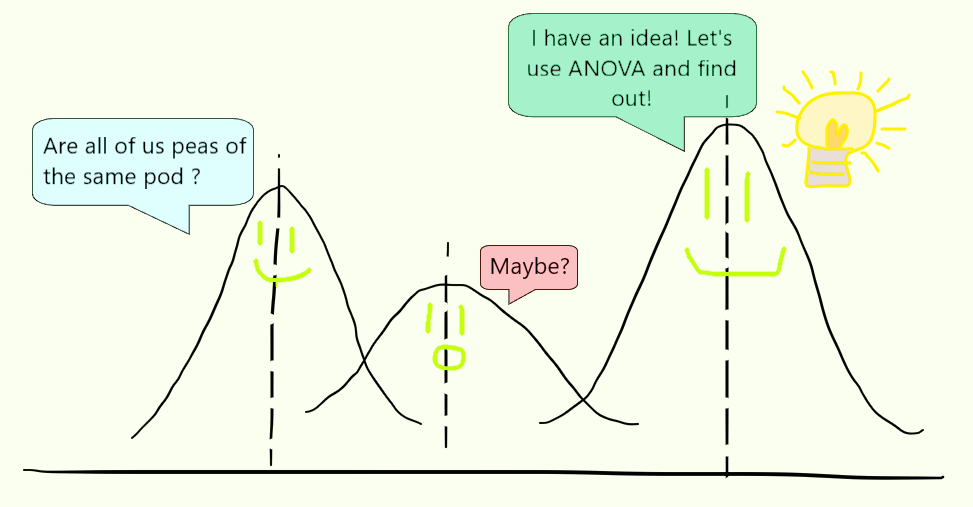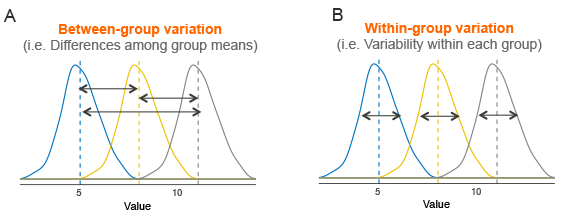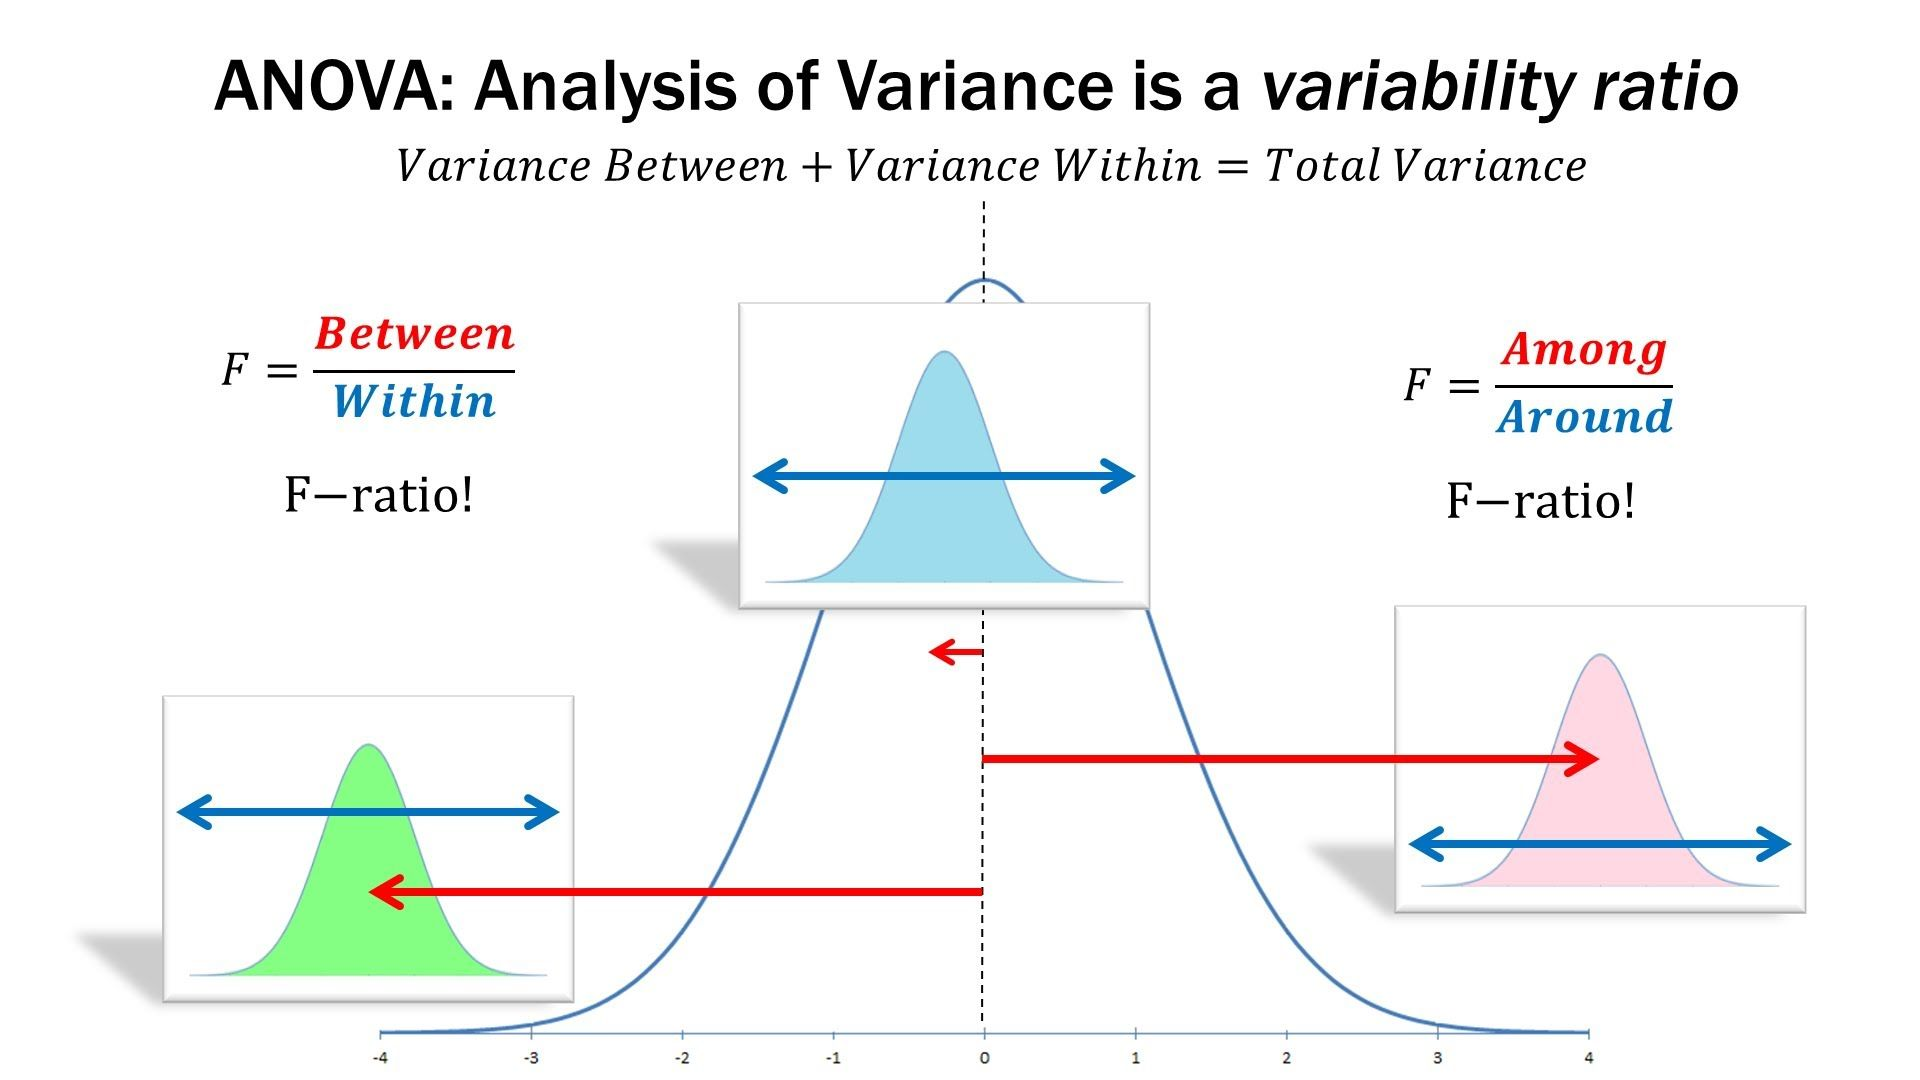

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
cat1 = df[df['Home Ownership']=='HaveMortgage']
cat2 = df[df['Home Ownership']=='Home Mortgage']
cat3 = df[df['Home Ownership']=='Own Home']
cat4 = df[df['Home Ownership']=='Rent']
qqplot(cat1['Annual Income'].dropna(),line='s')
qqplot(cat2['Annual Income'].dropna(),line='s')
qqplot(cat3['Annual Income'].dropna(),line='s')
qqplot(cat4['Annual Income'].dropna(),line='s')
pyplot.show()

In [ ]:
from scipy import stats
cat1 = df[df['Home Ownership']=='HaveMortgage']
cat2 = df[df['Home Ownership']=='Home Mortgage']
cat3 = df[df['Home Ownership']=='Own Home']
cat4 = df[df['Home Ownership']=='Rent']
for c in num_cols:   
    f_val, p_val = stats.f_oneway(cat1[c].dropna(), cat2[c].dropna(),cat3[c].dropna(),cat4[c].dropna())            
    print (c,"--- One-way ANOVA P =", p_val )

# Categorical vs Numerical

In [ ]:
for cat_col in cat_cols:
    for num_col in num_cols:    
        df.groupby(cat_col)[num_col].mean().plot(kind='bar',title=num_col)
        plt.show()    


# Modeling/Logestic Regression

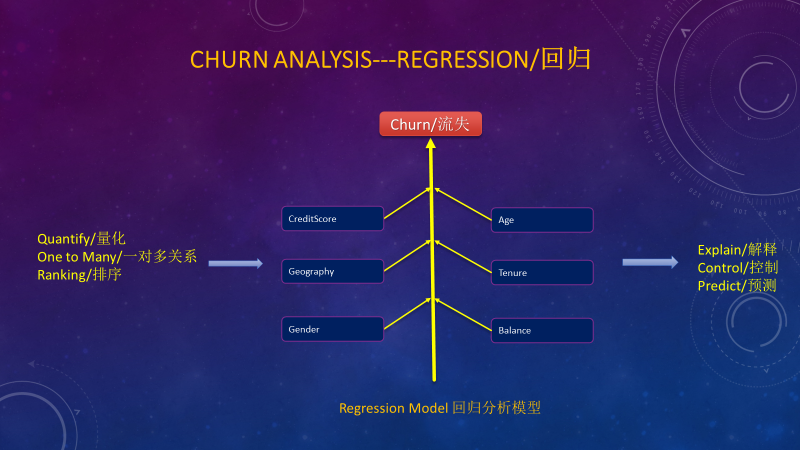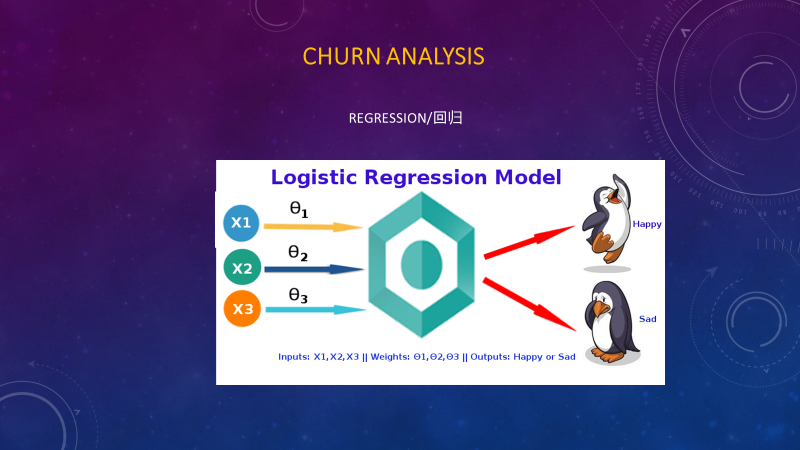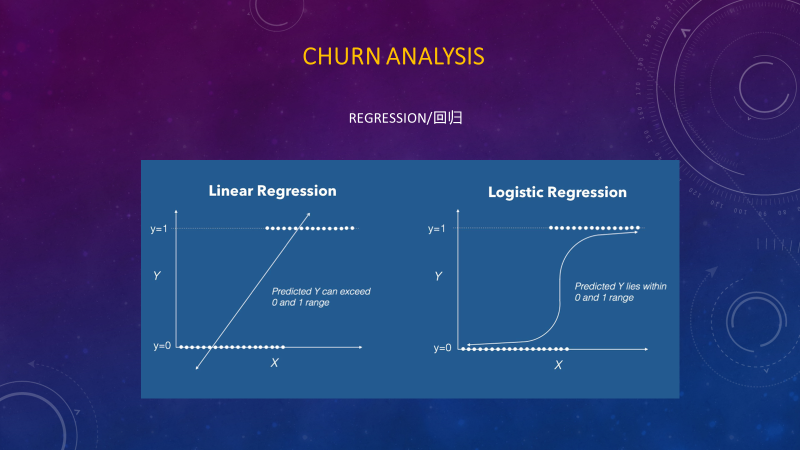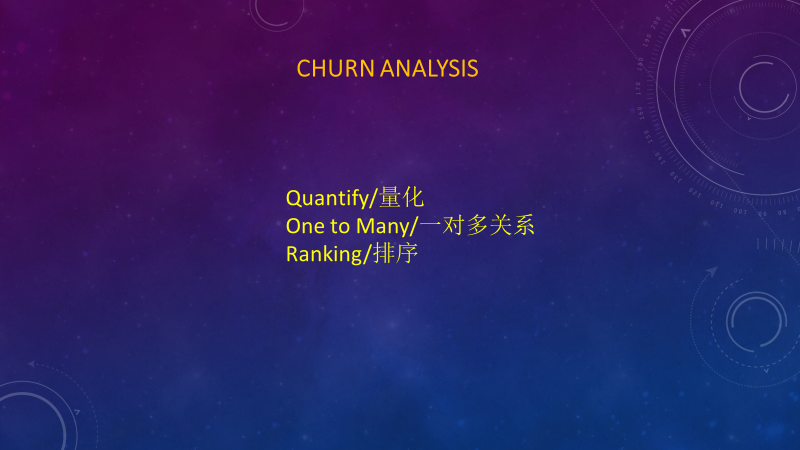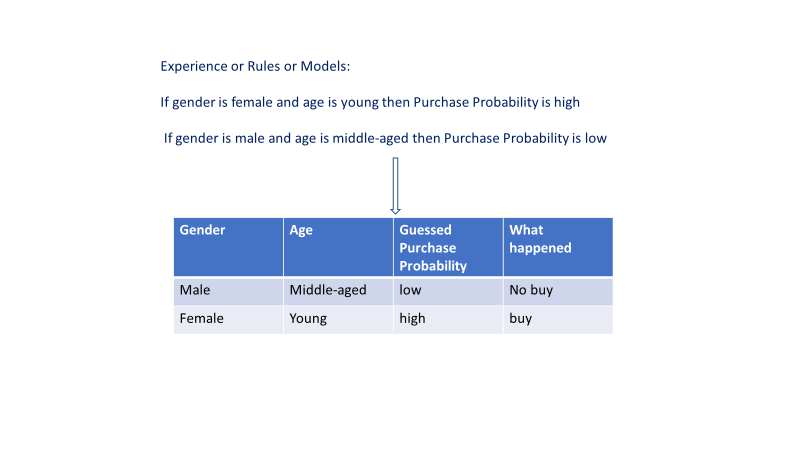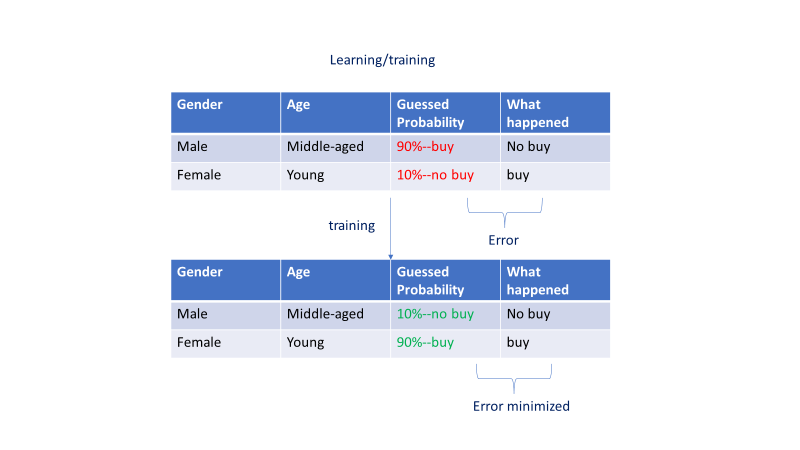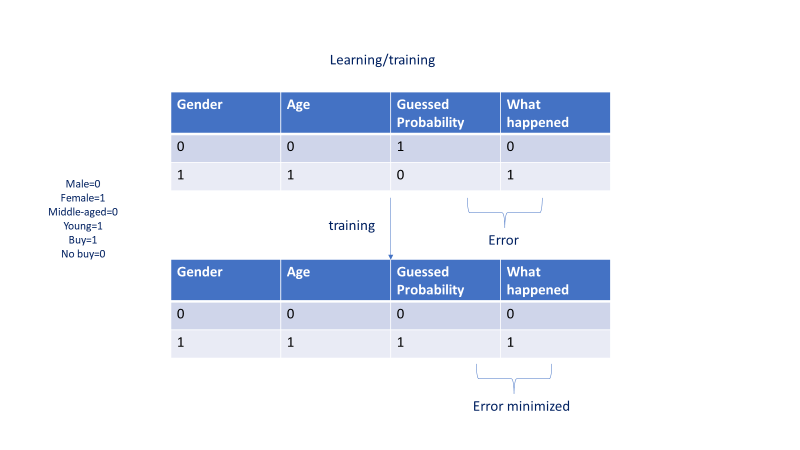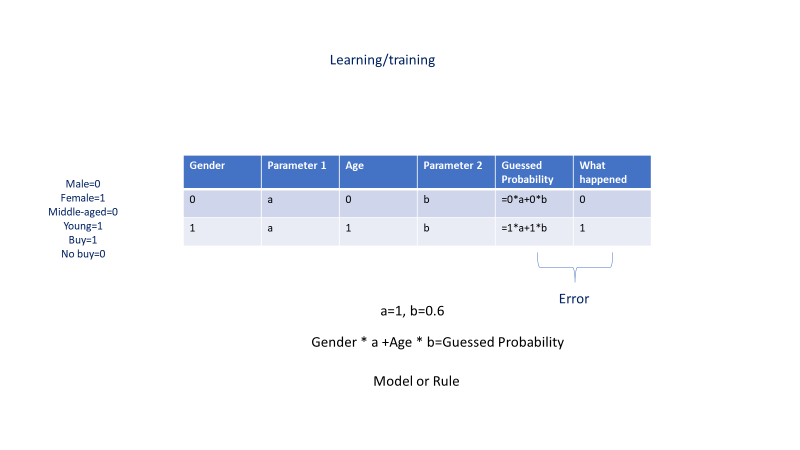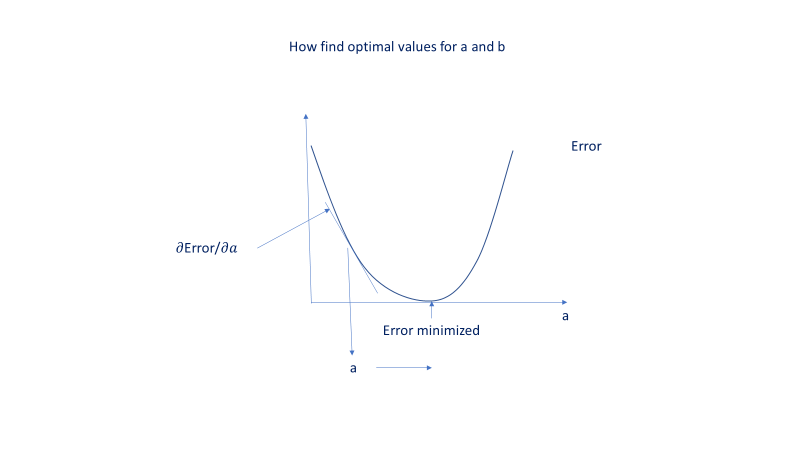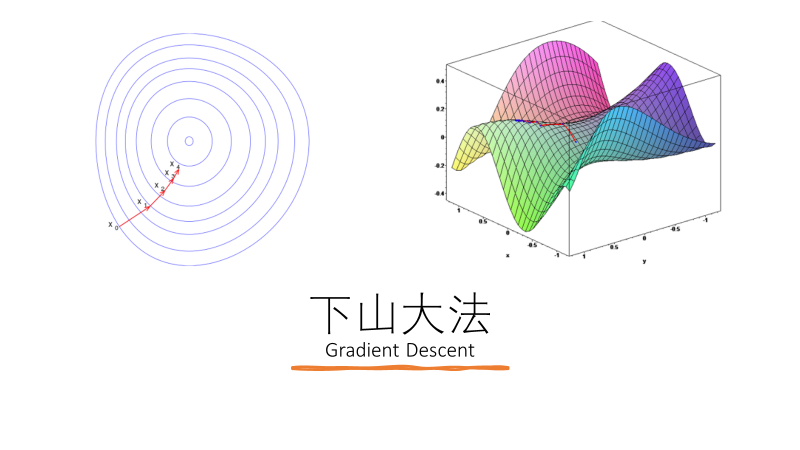

## Data processing and cleaning

In [172]:
df_train=pd.read_sql_table(r"credit_train",engine_datahub)
df_real=pd.read_sql_table(r"credit_test",engine_datahub)
df_train['data_ind']=1
df_real['data_ind']=0

df=pd.concat([df_train,df_real])
df[df['data_ind']==0]

Loan ID                           Customer ID Loan Status  Current Loan Amount        Term  Credit Score  Annual Income Years in current job Home Ownership             Purpose  Monthly Debt  Years of Credit History  Months since last delinquent  Number of Open Accounts  Number of Credit Problems  Current Credit Balance  Maximum Open Credit  Bankruptcies  Tax Liens  data_ind
0      f738779f-c726-40dc-92cf-689d73af533d  ded0b3c3-6bf4-4091-8726-47039f2c1b90         NaN             611314.0  Short Term         747.0      2074116.0            10+ years  Home Mortgage  Debt Consolidation      42000.83                     21.8                           NaN                      9.0                        0.0                621908.0            1058970.0           0.0        0.0         0
1      6dcc0947-164d-476c-a1de-3ae7283dde0a  1630e6e3-34e3-461a-8fda-09297d3140c8         NaN             266662.0  Short Term         734.0      1919190.0            10+ years  Home Mortgage  Debt Consolidation      36624.40                     19.4                           NaN                     11.0                        0.0                679573.0             904442.0           0.0        0.0         0
2      f7744d01-894b-49c3-8777-fc6431a2cff1  2c60938b-ad2b-4702-804d-eeca43949c52         NaN             153494.0  Short Term         709.0       871112.0              2 years           Rent  Debt Consolidation       8391.73                     12.5                          10.0                     10.0                        0.0                 38532.0             388036.0           0.0        0.0         0
3      83721ffb-b99a-4a0f-aea5-ef472a138b41  12116614-2f3c-4d16-ad34-d92883718806         NaN             176242.0  Short Term         727.0       780083.0            10+ years           Rent  Debt Consolidation      16771.87                     16.5                          27.0                     16.0                        1.0                156940.0             531322.0           1.0        0.0         0
4      08f3789f-5714-4b10-929d-e1527ab5e5a3  39888105-fd5f-4023-860a-30a3e6f5ccb7         NaN             321992.0  Short Term         744.0      1761148.0            10+ years  Home Mortgage  Debt Consolidation      39478.77                     26.0                          44.0                     14.0                        0.0                359765.0             468072.0           0.0        0.0         0
...                                     ...                                   ...         ...                  ...         ...           ...            ...                  ...            ...                 ...           ...                      ...                           ...                      ...                        ...                     ...                  ...           ...        ...       ...
10348                                  None                                  None        None                  NaN        None           NaN            NaN                 None           None                None           NaN                      NaN                           NaN                      NaN                        NaN                     NaN                  NaN           NaN        NaN         0
10349                                  None                                  None        None                  NaN        None           NaN            NaN                 None           None                None           NaN                      NaN                           NaN                      NaN                        NaN                     NaN                  NaN           NaN        NaN         0
10350                                  None                                  None        None                  NaN        None           NaN            NaN                 None           None                None           NaN                      NaN                           NaN                      NaN              

# Profiling the data

In [ ]:
# %pip install pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile

# Numericals

In [173]:
# limitPer = len(df) * .80
# df = df.dropna(thresh=limitPer, axis=1)

# limitPer=df.shape[1] * .50
# df = df.dropna(thresh=limitPer, axis=0)

df.shape
# df.head()

df['Years in current job']=df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)
num_cols=df.select_dtypes('number').columns.tolist()

df['Credit Score']=np.where(df['Credit Score']>=1000,df['Credit Score']/10,df['Credit Score'])
df['Current Loan Amount']=np.where(df['Current Loan Amount']==99999999,df['Current Loan Amount'].median(),df['Current Loan Amount'])

df[num_cols]=df[num_cols].clip(lower=df[num_cols].quantile(0.01), upper=df[num_cols].quantile(0.99),axis=1)
#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col in num_cols:
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))
    
df=df.query('`Loan ID`.notnull()',engine='python')

In [174]:
# df['Years in current job'].str[:2].replace({'< ':'0.5'}).astype(float)

In [175]:
# df[df['Years in current job'].str.contains('<').fillna(False)]

# Categoricals

In [176]:
cat_cols=df.select_dtypes(object).drop(['Loan ID','Customer ID'],axis=1).columns.tolist()
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in cat_cols:
    print(col)
    df[col]=imputer.fit_transform(df[col].values.reshape(-1, 1))


df.query('`Loan ID`.isnull()',engine='python')


Loan Status
Term
Home Ownership
Purpose


Empty DataFrame
Columns: [Loan ID, Customer ID, Loan Status, Current Loan Amount, Term, Credit Score, Annual Income, Years in current job, Home Ownership, Purpose, Monthly Debt, Years of Credit History, Months since last delinquent, Number of Open Accounts, Number of Credit Problems, Current Credit Balance, Maximum Open Credit, Bankruptcies, Tax Liens, data_ind]
Index: []

In [177]:
c='Purpose'
percentage=5
dct={}
series = pd.value_counts(df[c])
mask = (series/series.sum() * 100).lt(percentage)             
dct[c] = series[mask].index.values.tolist()
dct[c]
df[c] = np.where(df[c].isin(dct[c]),'Other',df[c])
df[c].value_counts()

Debt Consolidation    86430
Other                 10540
other                  6598
Home Improvements      6432
Name: Purpose, dtype: int64

In [178]:
# c='Purpose'
# series = pd.value_counts(df[c])
# series
(series/series.sum() * 100).lt(4)
series[mask].index.values.tolist()
# (series/series.sum() * 100).lt(percentage)   

['Other',
 'Business Loan',
 'Buy a Car',
 'Medical Bills',
 'Buy House',
 'Take a Trip',
 'major_purchase',
 'small_business',
 'moving',
 'wedding',
 'Educational Expenses',
 'vacation',
 'renewable_energy']

In [179]:
mask = (series/series.sum() * 100).lt(percentage)     

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       110000 non-null  object 
 1   Customer ID                   110000 non-null  object 
 2   Loan Status                   110000 non-null  object 
 3   Current Loan Amount           110000 non-null  float64
 4   Term                          110000 non-null  object 
 5   Credit Score                  110000 non-null  float64
 6   Annual Income                 110000 non-null  float64
 7   Years in current job          110000 non-null  float64
 8   Home Ownership                110000 non-null  object 
 9   Purpose                       110000 non-null  object 
 10  Monthly Debt                  110000 non-null  float64
 11  Years of Credit History       110000 non-null  float64
 12  Months since last delinquent  110000 non-null 

In [181]:
num_cols,cat_cols

(['Current Loan Amount',
  'Credit Score',
  'Annual Income',
  'Years in current job',
  'Monthly Debt',
  'Years of Credit History',
  'Months since last delinquent',
  'Number of Open Accounts',
  'Number of Credit Problems',
  'Current Credit Balance',
  'Maximum Open Credit',
  'Bankruptcies',
  'Tax Liens',
  'data_ind'],
 ['Loan Status', 'Term', 'Home Ownership', 'Purpose'])

In [182]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

Column_Name  Num_Unique
19                      data_ind           2
17                  Bankruptcies           2
2                    Loan Status           2
4                           Term           2
18                     Tax Liens           2
14     Number of Credit Problems           3
8                 Home Ownership           4
9                        Purpose           4
7           Years in current job          11
13       Number of Open Accounts          25
12  Months since last delinquent          81
5                   Credit Score         130
11       Years of Credit History         339
3            Current Loan Amount       22015
15        Current Credit Balance       32641
6                  Annual Income       36492
16           Maximum Open Credit       45368
10                  Monthly Debt       68146
1                    Customer ID       88354
0                        Loan ID       88354

In [183]:
[(col, df[col].nunique()) for col in df.columns]

[('Loan ID', 88354),
 ('Customer ID', 88354),
 ('Loan Status', 2),
 ('Current Loan Amount', 22015),
 ('Term', 2),
 ('Credit Score', 130),
 ('Annual Income', 36492),
 ('Years in current job', 11),
 ('Home Ownership', 4),
 ('Purpose', 4),
 ('Monthly Debt', 68146),
 ('Years of Credit History', 339),
 ('Months since last delinquent', 81),
 ('Number of Open Accounts', 25),
 ('Number of Credit Problems', 3),
 ('Current Credit Balance', 32641),
 ('Maximum Open Credit', 45368),
 ('Bankruptcies', 2),
 ('Tax Liens', 2),
 ('data_ind', 2)]

In [184]:
(col, df[col].nunique())

('Purpose', 4)

In [185]:
df.query('`Loan ID`.notnull()',engine='python')

Loan ID                           Customer ID Loan Status  Current Loan Amount        Term  Credit Score  Annual Income  Years in current job Home Ownership             Purpose  Monthly Debt  Years of Credit History  Months since last delinquent  Number of Open Accounts  Number of Credit Problems  Current Credit Balance  Maximum Open Credit  Bankruptcies  Tax Liens  data_ind
0     14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041a9ca9  Fully Paid             445412.0  Short Term         709.0      1167493.0                   8.0  Home Mortgage   Home Improvements       5214.74                     17.2                          32.0                      6.0                        1.0                228190.0             416746.0           1.0        0.0       1.0
1     4771cc26-131a-45db-b5aa-537ea4ba5342  2de017a3-2e01-49cb-a581-08169e83be29  Fully Paid             262328.0  Short Term         722.0      1173459.0                  10.0  Home Mortgage  Debt Consolidation      33295.98                     21.1                           8.0                     27.0                        0.0                229976.0             850784.0           0.0        0.0       1.0
2     4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  5efb2b2b-bf11-4dfd-a572-3761a2694725  Fully Paid             312026.0  Short Term         741.0      2231892.0                   8.0       Own Home  Debt Consolidation      29200.53                     14.9                          29.0                     18.0                        1.0                297996.0             750090.0           0.0        0.0       1.0
3     77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  e777faab-98ae-45af-9a86-7ce5b33b1011  Fully Paid             347666.0   Long Term         721.0       806949.0                   3.0       Own Home  Debt Consolidation       8741.90                     12.0                          32.0                      9.0                        0.0                256329.0             386958.0           0.0        0.0       1.0
4     d4062e70-befa-4995-8643-a0de73938182  81536ad9-5ccf-4eb8-befb-47a4d608658e  Fully Paid             176220.0  Short Term         722.0      1173459.0                   5.0           Rent  Debt Consolidation      20639.70                      6.4                          32.0                     15.0                        0.0                253460.0             427174.0           0.0        0.0       1.0
...                                    ...                                   ...         ...                  ...         ...           ...            ...                   ...            ...                 ...           ...                      ...                           ...                      ...                        ...                     ...                  ...           ...        ...       ...
9995  c4ab66f9-833c-43b8-879c-4f8bcb64dd14  8ee2002b-8fb6-4af0-ab74-25a1c23e7647  Fully Paid             157806.0  Short Term         731.0      1514376.0                   6.0           Rent  Debt Consolidation       4795.41                     12.5                          32.0                      9.0                        0.0                 87058.0             234410.0           0.0        0.0       0.0
9996  bbd3a392-01b4-4e0e-9c28-b2a4a39beac7  6c306306-f5c2-4db5-b74a-af2895123ecb  Fully Paid             132550.0  Short Term         718.0       763192.0                   4.0  Home Mortgage  Debt Consolidation      12401.87                      9.9                          20.0                      8.0                        0.0                 74309.0             329692.0           0.0        0.0       0.0
9997  da9870de-4280-46a3-8fc6-91cfe5bfde9d  cc94e25e-1060-4465-b603-194e122f0239  Fully Paid             223212.0   Long Term         722.0      1173459.0                   6.0           Rent  Debt Consolidation       4354.42                     27.2                          32.0                      8.0             

In [186]:
#check for missing values
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Loan ID, Customer ID, Loan Status, Current Loan Amount, Term, Credit Score, Annual Income, Years in current job, Home Ownership, Purpose, Monthly Debt, Years of Credit History, Months since last delinquent, Number of Open Accounts, Number of Credit Problems, Current Credit Balance, Maximum Open Credit, Bankruptcies, Tax Liens, data_ind]
Index: []

In [187]:
df['Purpose'],pd.get_dummies(df['Purpose'], prefix='Purpose', drop_first=False)

(0        Home Improvements
 1       Debt Consolidation
 2       Debt Consolidation
 3       Debt Consolidation
 4       Debt Consolidation
                ...        
 9995    Debt Consolidation
 9996    Debt Consolidation
 9997    Debt Consolidation
 9998    Debt Consolidation
 9999    Debt Consolidation
 Name: Purpose, Length: 110000, dtype: object,
       Purpose_Debt Consolidation  Purpose_Home Improvements  Purpose_Other  Purpose_other
 0                              0                          1              0              0
 1                              1                          0              0              0
 2                              1                          0              0              0
 3                              1                          0              0              0
 4                              1                          0              0              0
 ...                          ...                        ...            ...            ...
 9995   

In [188]:
#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df


cat_cols.remove('Loan Status')
df=one_hot(df,cat_cols)
df.head()

Loan ID                           Customer ID Loan Status  Current Loan Amount  Credit Score  Annual Income  Years in current job  Monthly Debt  Years of Credit History  Months since last delinquent  Number of Open Accounts  Number of Credit Problems  Current Credit Balance  Maximum Open Credit  Bankruptcies  Tax Liens  data_ind  Term_Long Term  Term_Short Term  Home Ownership_HaveMortgage  Home Ownership_Home Mortgage  Home Ownership_Own Home  Home Ownership_Rent  Purpose_Debt Consolidation  Purpose_Home Improvements  Purpose_Other  Purpose_other
0  14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041a9ca9  Fully Paid             445412.0         709.0      1167493.0                   8.0       5214.74                     17.2                          32.0                      6.0                        1.0                228190.0             416746.0           1.0        0.0       1.0               0                1                            0                             1                        0                    0                           0                          1              0              0
1  4771cc26-131a-45db-b5aa-537ea4ba5342  2de017a3-2e01-49cb-a581-08169e83be29  Fully Paid             262328.0         722.0      1173459.0                  10.0      33295.98                     21.1                           8.0                     27.0                        0.0                229976.0             850784.0           0.0        0.0       1.0               0                1                            0                             1                        0                    0                           1                          0              0              0
2  4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  5efb2b2b-bf11-4dfd-a572-3761a2694725  Fully Paid             312026.0         741.0      2231892.0                   8.0      29200.53                     14.9                          29.0                     18.0                        1.0                297996.0             750090.0           0.0        0.0       1.0               0                1                            0                             0                        1                    0                           1                          0              0              0
3  77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  e777faab-98ae-45af-9a86-7ce5b33b1011  Fully Paid             347666.0         721.0       806949.0                   3.0       8741.90                     12.0                          32.0                      9.0                        0.0                256329.0             386958.0           0.0        0.0       1.0               1                0                            0                             0                        1                    0                           1                          0              0              0
4  d4062e70-befa-4995-8643-a0de73938182  81536ad9-5ccf-4eb8-befb-47a4d608658e  Fully Paid             176220.0         722.0      1173459.0                   5.0      20639.70                      6.4                          32.0                     15.0                        0.0                253460.0             427174.0           0.0        0.0       1.0               0                1                            0                             0                        0                    1                           1                          0              0              0

# split the data into new data and training data

In [189]:
df_new_data=df[df['data_ind']==0]
df=df[df['data_ind']==1]

# create the X list for model

In [190]:
item_list = df.columns.tolist()
item_list = [e for e in item_list if e not in ('Loan ID','Customer ID','Loan Status','Loan Status encoded','data_ind')]
item_list

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Years in current job',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens',
 'Term_Long Term',
 'Term_Short Term',
 'Home Ownership_HaveMortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_Debt Consolidation',
 'Purpose_Home Improvements',
 'Purpose_Other',
 'Purpose_other']

In [191]:
#double check the data to see if there is any missing values and all categorical attributes have been encoded.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Credit Score                  100000 non-null  float64
 5   Annual Income                 100000 non-null  float64
 6   Years in current job          100000 non-null  float64
 7   Monthly Debt                  100000 non-null  float64
 8   Years of Credit History       100000 non-null  float64
 9   Months since last delinquent  100000 non-null  float64
 10  Number of Open Accounts       100000 non-null  float64
 11  Number of Credit Problems     100000 non-null  float64
 12  Current Credit Balance        100000 non-null

# Checking for multicollinearity using VIF(Variance Inflation Factor)

In [192]:
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

import statsmodels.formula.api as sm
vif_cal(df[item_list+['Loan Status']],'Loan Status')

Current Loan Amount  VIF =  1.63
Credit Score  VIF =  1.34
Annual Income  VIF =  1.6
Years in current job  VIF =  1.1
Monthly Debt  VIF =  2.1
Years of Credit History  VIF =  1.18
Months since last delinquent  VIF =  1.01
Number of Open Accounts  VIF =  1.4
Number of Credit Problems  VIF =  5.39
Current Credit Balance  VIF =  3.47
Maximum Open Credit  VIF =  3.27
Bankruptcies  VIF =  4.28
Tax Liens  VIF =  1.92
Term_Long Term  VIF =  inf
Term_Short Term  VIF =  inf
Home Ownership_HaveMortgage  VIF =  inf
Home Ownership_Home Mortgage  VIF =  inf
Home Ownership_Own Home  VIF =  inf
Home Ownership_Rent  VIF =  inf
Purpose_Debt Consolidation  VIF =  inf
Purpose_Home Improvements  VIF =  inf
Purpose_Other  VIF =  inf
Purpose_other  VIF =  inf


# Feature selection

In [193]:
y =df['Loan Status'].map({'Fully Paid':0,'Charged Off':1})# target variable
X= df[item_list]# features after dropping the  target (diagnosis) & ID
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### KBest

In [194]:
from sklearn.feature_selection import SelectKBest, chi2
X_5_best= SelectKBest(chi2, k=15).fit(x_train, y_train)
mask = X_5_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, x_train.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat)) # The list of your 5 best features

The best features are:['Current Loan Amount', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Term_Long Term', 'Term_Short Term', 'Home Ownership_HaveMortgage', 'Home Ownership_Home Mortgage', 'Home Ownership_Rent', 'Purpose_Home Improvements', 'Purpose_Other', 'Purpose_other']


### RFECV

In [195]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFECV
# cv_estimator = RandomForestClassifier(random_state =42)
# cv_estimator.fit(X_train, Y_train)
# cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
# cv_selector = cv_selector.fit(X_train, Y_train)
# rfecv_mask = cv_selector.get_support() #list of booleans
# rfecv_features = [] 
# for bool, feature in zip(rfecv_mask, X_train.columns):
#     if bool:
#         rfecv_features.append(feature)
# print('Optimal number of features :', cv_selector.n_features_)
# print('Best features :', rfecv_features)


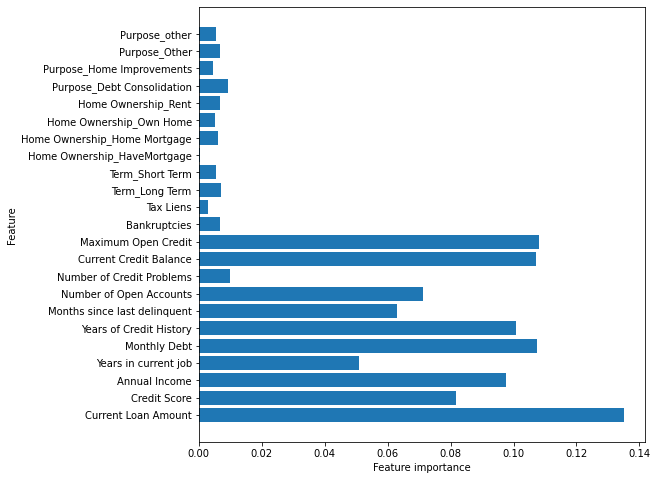

In [196]:

n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

## Algorithm selection
Sometimes it's difficult to know which algorithm to use to train the model because each algorithm has its pros and cons so we test mainstream algorithms and pick the one with the best 
performance.

LR: 0.618339 (0.009254)
LDA: 0.617113 (0.009521)
KNN: 0.569983 (0.008722)
CART: 0.574142 (0.007740)
NB: 0.597599 (0.006854)


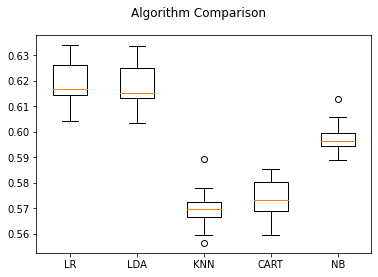

In [197]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[item_list]),columns=item_list)
                   
df['Loan Status encoded']=np.where(df['Loan Status']=='Fully Paid',0,1)                   
                   
# load dataset
x_train, x_test, y_train, y_test = train_test_split(df_x, df['Loan Status encoded'], 
                                                    test_size = .25)

X = x_train
Y = y_train

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Select the best algorithm and do Grid Search for the best Hyper Parameters.
From the above boxplot we can see that the attributes are very powerful predictors and all algorithms have high performance.
In this case we choose Logistic Regression due to it's better interpretability. To further improve the performance we do Grid Search
to find the best Hyper Parameters for Logistic Regression

In [198]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.7718666666666667


## Create the function to train the model, test it, and visualize the results

In [199]:
def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Loan Status 0", "Loan Status 1"],
                        y = ["Loan Status 0", "Loan Status 1"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        display(coef_sumry)
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        

        
    py.iplot(fig)
    return(coef_sumry,algorithm)



## Feed the parameters to the function created above
Split the data into train dataset and test dataset and use the Hyper Parameters obtained above to generate a Logistic Regression instance and execute the function.

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
# from yellowbrick.classifier import DiscriminationThreshold

#For better performance use MinMaxScaler to scale and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[item_list]),columns=item_list)
                   
df['Loan Status encoded']=np.where(df['Loan Status']=='Fully Paid',0,1)   

#splitting the principal training dataset to subtrain and subtest datasets

x_train, x_test, y_train, y_test = train_test_split(df_x, df['Loan Status encoded'], 
                                                    test_size = .3)
from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
#Baseline model        
# logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
#                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#                            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
#                            verbose=0, warm_start=False)
logit = LogisticRegression(C=0.1,penalty='l1',solver='liblinear')

coef_sumry, model=prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=False)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87     23123
           1       0.00      0.00      0.00      6877

    accuracy                           0.77     30000
   macro avg       0.39      0.50      0.44     30000
weighted avg       0.59      0.77      0.67     30000

Accuracy Score: 0.7707
Area under curve: 0.4999567530164771 



coefficients                      features
9       0.993966        Current Credit Balance
4       0.523872                  Monthly Debt
0       0.383151           Current Loan Amount
7       0.309010       Number of Open Accounts
18      0.161764           Home Ownership_Rent
12      0.116572                     Tax Liens
8       0.059889     Number of Credit Problems
21      0.017900                 Purpose_Other
3       0.004971          Years in current job
17      0.000000       Home Ownership_Own Home
13      0.000000                Term_Long Term
22      0.000000                 Purpose_other
5       0.000000       Years of Credit History
20     -0.002674     Purpose_Home Improvements
15     -0.014684   Home Ownership_HaveMortgage
19     -0.060961    Purpose_Debt Consolidation
16     -0.095148  Home Ownership_Home Mortgage
11     -0.096516                  Bankruptcies
6      -0.157294  Months since last delinquent
1      -0.298113                  Credit Score
14     -0.519034               Term_Short Term
10     -1.680188           Maximum Open Credit
2      -2.009143                 Annual Income

### Interpret the results:
<!-- An Accuracy Score of 0.96 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 194 predictions, only 7 mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.965, also near perfect. 
The Feature Importance chart  suggests that  Money_Values, PARA_B, PARA_A, Score and District_Loss are more powerful predictors for Risk. 
 -->
<!-- Overall we have a very good model that can predict Risk. -->

# Productization of your Insights/Recommendations

In [201]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [202]:
df_new_data=df_new_data.query('`Loan ID`.notnull()',engine='python')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df_new_data[item_list]),columns=item_list)
df_new_data['probability'] = model.predict_proba(df_x)[:,1]
df_new_data.sort_values(by='probability',ascending=False).head(50)
df_new_data=df_new_data.drop('Purpose_other',axis=1)

In [205]:
df_new_data


Loan ID                           Customer ID Loan Status  Current Loan Amount  Credit Score  Annual Income  Years in current job  Monthly Debt  Years of Credit History  Months since last delinquent  Number of Open Accounts  Number of Credit Problems  Current Credit Balance  Maximum Open Credit  Bankruptcies  Tax Liens  data_ind  Term_Long Term  Term_Short Term  Home Ownership_HaveMortgage  Home Ownership_Home Mortgage  Home Ownership_Own Home  Home Ownership_Rent  Purpose_Debt Consolidation  Purpose_Home Improvements  Purpose_Other  probability
0     f738779f-c726-40dc-92cf-689d73af533d  ded0b3c3-6bf4-4091-8726-47039f2c1b90  Fully Paid             611314.0         747.0      2074116.0                  10.0      42000.83                     21.8                          32.0                      9.0                        0.0                621908.0            1058970.0           0.0        0.0       0.0               0                1                            0                             1                        0                    0                           1                          0              0     0.164576
1     6dcc0947-164d-476c-a1de-3ae7283dde0a  1630e6e3-34e3-461a-8fda-09297d3140c8  Fully Paid             266662.0         734.0      1919190.0                  10.0      36624.40                     19.4                          32.0                     11.0                        0.0                679573.0             904442.0           0.0        0.0       0.0               0                1                            0                             1                        0                    0                           1                          0              0     0.166127
2     f7744d01-894b-49c3-8777-fc6431a2cff1  2c60938b-ad2b-4702-804d-eeca43949c52  Fully Paid             153494.0         709.0       871112.0                   2.0       8391.73                     12.5                          10.0                     10.0                        0.0                 38532.0             388036.0           0.0        0.0       0.0               0                1                            0                             0                        0                    1                           1                          0              0     0.220762
3     83721ffb-b99a-4a0f-aea5-ef472a138b41  12116614-2f3c-4d16-ad34-d92883718806  Fully Paid             176242.0         727.0       780083.0                  10.0      16771.87                     16.5                          27.0                     16.0                        1.0                156940.0             531322.0           1.0        0.0       0.0               0                1                            0                             0                        0                    1                           1                          0              0     0.234874
4     08f3789f-5714-4b10-929d-e1527ab5e5a3  39888105-fd5f-4023-860a-30a3e6f5ccb7  Fully Paid             321992.0         744.0      1761148.0                  10.0      39478.77                     26.0                          44.0                     14.0                        0.0                359765.0             468072.0           0.0        0.0       0.0               0                1                            0                             1                        0                    0                           1                          0              0     0.183406
...                                    ...                                   ...         ...                  ...           ...            ...                   ...           ...                      ...                           ...                      ...                        ...                     ...                  ...           ...        ...       ...             ...              ...                          ...                           ...                      ...                  ...          

In [206]:
# df_new_data=df_new_data.drop('Purpose_other',axis=1)
df_new_data.to_sql('credit_prediction1',engine_datahub,if_exists='replace',index=False)

In [ ]:
# df_final=pd.merge(pd.read_sql_table(r"credit_test",engine_datahub),df_new_data[['Loan ID','probabily']], on=['Loan ID'])
# df_final

In [ ]:
# coef_sumry['abs_coef']=abs(coef_sumry['coefficients'])
# coef_sumry=coef_sumry.sort_values(by = "abs_coef", ascending=False)
# coef_sumry['features'][:10].tolist()

In [ ]:
# target='Loan Status'
# one='Charged Off'
# numerical_features=['Annual Income','Maximum Open Credit','Current Credit Balance','Monthly Debt','Current Loan Amount',
#                     'Number of Open Accounts', 'Credit Score']
# categorical_features=['Term','Home Ownership']
# #build ML pipeline and fit the model 
# X = df[numerical_features+categorical_features]
# df['class_labels']=np.where(df[target]==one,1,0)
# y = df['class_labels'].values 

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

In [ ]:
# # df_new[numerical_features+categorical_features].isnull().sum()


# ##regularization
# c=0.5
# upper_limit=0.95
# lower_limit=0.01

# from sklearn.base import BaseEstimator,TransformerMixin

# # class CategoricalTransformer(BaseEstimator, TransformerMixin):
# #     def __init__(self):
# #         '''binning categorical columns'''
        
# #     def fit(self,X,y=None):
# #         self.dct={}
# #         for c in X.columns:
# #             self.series = pd.value_counts(X[c])
# #             self.mask = (self.series/self.series.sum() * 100).lt(percentage)             
# #             self.dct[c] = self.series[self.mask].index.values.tolist()
# #         return self   
    
# #     def transform(self,X,y=None):         
# #         for c in X.columns.tolist(): 
# # #             print(self.dct[c])
# # #             X[c] = np.where(X[c].isin(self.dct[c]),'Other',X[c]) 
# #             X[c] = np.where(X[c].isin(self.dct[c]),'--- Not in '+','.join(self.dct[c])[:20],X[c])
# #         return X
    

    
# class NumericalTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self,lower_limit,upper_limit):
#         '''clipping outliers'''
#         self.lower_limit=lower_limit
#         self.upper_limit=upper_limit
        
#     def fit(self,X,y=None):
#         self.lower={}
#         self.upper={}
#         for c in X.columns:
#             self.lower[c]=X[c].quantile(self.lower_limit)
#             self.upper[c]=X[c].quantile(self.upper_limit)   
#         return self    
            
#     def transform(self,X,y=None):         
#         for c in X.columns.tolist(): 
#             X[c] = np.where(X[c] <self.lower[c], self.lower[c],X[c])
#             X[c] = np.where(X[c] >self.upper[c], self.upper[c],X[c])
#         return X    
    
    
 

# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.linear_model import LogisticRegression


# numeric_transformer = Pipeline( steps = [ 
                                  
#                                   ( 'num_transformer', NumericalTransformer(lower_limit,upper_limit) ),
                                  
#                                   ('num_imputer', SimpleImputer( strategy='median') ),
                                  
#                                   ( 'std_scaler', StandardScaler() ) ] )


# categorical_transformer = Pipeline( steps = [ 
                                
# #                                   ( 'cat_transformer', CategoricalTransformer() ),    
#                                             ('cat_imputer', SimpleImputer( strategy='most_frequent')),
#                                   ( 'one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse = False ) ) ] )

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)])

# full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('model',  LogisticRegression(C=c, penalty='l1',solver='liblinear'))])



# #Can call fit on it just like any other pipeline
# full_pipeline.fit( X_train, y_train )

# #Can predict with it like any other pipeline
# y_pred = full_pipeline.predict( X_test ) 






# #SAVE THE Pipeline
# import dill

# with open('pipeline_Credit.pkl','wb') as io:
#     dill.dump(full_pipeline,io)
    

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
# from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
# from sklearn.metrics import precision_recall_curve, average_precision_score

# THRESHOLD = 0.25
# preds = np.where(full_pipeline.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

# pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
#                    precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
#              index=["accuracy", "recall", "precision", "roc_auc_score"])

In [ ]:
#visulize model perfromance and explain the model

# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
# from sklearn.metrics import roc_auc_score, roc_curve,f1_score, precision_score, recall_score
# from sklearn.metrics import precision_recall_curve, average_precision_score

# import plotly.graph_objs as go # visualization
# import plotly.offline as py # visualization
# py.init_notebook_mode(connected=True) # visualization
# import plotly.graph_objs as go # visualization
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff # visualization

# cols_list=numerical_features+list(full_pipeline['preprocessor'].transformers_[1][1]\
#    ['one_hot_encoder'].get_feature_names(categorical_features))

# def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
#     #model
#     algorithm.fit(training_x, training_y)
#     predictions = algorithm.predict(testing_x)
#     probabilities = algorithm.predict_proba(testing_x)
        
#     print('Algorithm:', type(algorithm).__name__)
#     print("\nClassification report:\n", classification_report(testing_y, predictions))
#     print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
#     #confusion matrix
#     conf_matrix = confusion_matrix(testing_y, predictions)
#     #roc_auc_score
#     model_roc_auc = roc_auc_score(testing_y, predictions) 
#     print("Area under curve:", model_roc_auc,"\n")
    
#     fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
#     #plot confusion matrix
#     trace1 = go.Heatmap(z = conf_matrix,
#                         x = ["0", "1"],
#                         y = ["0", "1"],
#                         showscale = False, colorscale = "Picnic",
#                         name = "Confusion matrix")
    
#     #plot roc curve
#     trace2 = go.Scatter(x = fpr, y = tpr,
#                         name = "Roc: " + str(model_roc_auc),
#                         line = dict(color = ('rgb(22, 96, 167)'), width = 2))
#     trace3 = go.Scatter(x = [0,1], y = [0,1],
#                         line = dict(color = ('rgb(205, 12, 24)'), width = 2,
#                         dash = 'dot'))
    
#     if cf in ['coefficients', 'features']:
#         if cf == 'coefficients':
#             coefficients = pd.DataFrame(algorithm['model'].coef_.ravel())
#         elif cf == 'features':
#             coefficients = pd.DataFrame(algorithm['model'].feature_importances_)
        
#         column_df = pd.DataFrame(cols_list)
#         coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
#                                right_index=True, how="left"))
        
#         coef_sumry.columns = ["coefficients", "features"]
#         coef_sumry=coef_sumry.query('coefficients!=0')
#         coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
#         #plot coeffs
#         trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
#                         name = "coefficients",
#                         marker = dict(color = coef_sumry["coefficients"],
#                                       colorscale = "Picnic",
#                                       line = dict(width = .6, color = "black")
#                                      )
#                        )
#         #subplots
#         fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
#                                 subplot_titles=('Confusion matrix',
#                                                 'Receiver operating characteristic',
#                                                 'Feature importances')
#                            )  
#         fig.append_trace(trace1,1,1)
#         fig.append_trace(trace2,1,2)
#         fig.append_trace(trace3,1,2)
#         fig.append_trace(trace4,2,1)
#         fig['layout'].update(showlegend=False, title="Model performance",
#                              autosize=False, height = 900, width = 800,
#                              plot_bgcolor = 'rgba(240,240,240, 0.95)',
#                              paper_bgcolor = 'rgba(240,240,240, 0.95)',
#                              margin = dict(b = 195))
#         fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
#         fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
#         fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = -50))
 
        
#     py.iplot(fig)
    

        
# prediction(full_pipeline, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=False)        


In [ ]:
# import dill
# with open('pipeline_Credit.pkl','rb') as io:
#     model=dill.load(io)

# # df_score=df_new[['ProjectWorkID']+numerical_features+categorical_features]

# # df['ML_Prediction'] = model.predict(df[numerical_features+categorical_features])
# df['probabily'] = model.predict_proba(df[numerical_features+categorical_features])[:,1]
# df.sort_values(by='probabily',ascending=False).head(50)